# Parts Distributor SKU classifier, part 2: Explore the model

In [part 1](parts-distributor-sku-classifier-part-1.ipynb) we built a model that can classify strings like `SN74LVC541APWR` or `296-8521-1-ND` as either manufacturer part numbers, Mouser SKUs or Digi-Key SKUs. In part 2, we will load that model and run it on various inputs to get a feel for how it works.

## Load the model

First let's load the model and the training data back into memory.

In [1]:
import pandas as pd
import numpy as np
import json
from IPython.display import Markdown, display
from keras.models import model_from_json
import graphviz
from IPython.display import SVG

Using TensorFlow backend.


In [2]:
# Load the model architecture
with open("data/trained_model_layers.json", 'r') as json_file:
    model = model_from_json(json_file.read())

# Load the model weights
model.load_weights("data/trained_model_weights.h5")

# Compile the model
batch_size = 32
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Load the data set
df = pd.read_json("data/cleaned_training_data.json")

# Load the dictionary
with open("data/char_dictionary.json", 'r') as json_file:
    partnum_dict = json.load(json_file)
    
class_names = ['MPN', 'Mouser SKU', 'Digi-Key SKU']

def d(col, ds, class_filter=None, df=df):
    if class_filter is not None:
        return list(df[(df['dataset'] == ds) & (df['class'] == class_filter)][col])
    else:
        return list(df[df['dataset'] == ds][col])
    
df.head()

,class,dataset,partnum,x,y
0,2,train,296-8311-6-ND,"[22, 46, 29, 9, 12, 3, 50, 50, 9, 29, 9, 17, 4...","[0.0, 0.0, 1.0]"
1,2,train,MCP1702T-3302E/CBCT-ND,"[32, 16, 23, 50, 26, 24, 22, 37, 9, 3, 3, 24, ...","[0.0, 0.0, 1.0]"
10,1,val,595-TPS65986ABZQZR,"[10, 46, 10, 9, 37, 23, 35, 29, 10, 46, 12, 29...","[0.0, 1.0, 0.0]"
100,2,train,A109694TR-ND,"[7, 50, 24, 46, 29, 46, 25, 37, 38, 9, 17, 44,...","[0.0, 0.0, 1.0]"
1000,2,train,LP5900SD-3.0/NOPBCT-ND,"[19, 23, 10, 46, 24, 24, 35, 44, 9, 3, 5, 24, ...","[0.0, 0.0, 1.0]"


In [3]:
# Test the model to make sure it's loaded correctly
score, acc = model.evaluate(d('x', 'val'), d('y', 'val'), batch_size=batch_size)
display(Markdown('### Accuracy of the model: {:.2f}%'.format(acc * 100.0)))
res = []
for c in sorted(df['class'].unique()):
    score, acc = model.evaluate(d('x', 'val', class_filter=c), d('y', 'val', class_filter=c), batch_size=batch_size)
    res.append([class_names[c], '{:.2f}%'.format(acc*100.0)])
pd.DataFrame(res, columns=['class', 'accuracy'])

2720/2789 [============================>.] - ETA: 0s

### Accuracy of the model: 99.01%

800/921 [=========================>....] - ETA: 0s

,class,accuracy
0,MPN,97.49%
1,Mouser SKU,99.51%
2,Digi-Key SKU,100.00%


The model is miscategorizing some of the MPNs. Let's visualize the confusion.

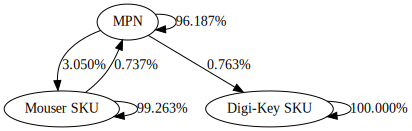

In [4]:
def cross_category_bleeding(model, x_test, y_test, batch_size):
    preds = model.predict(x_test)
    cat_count = np.shape(y_test)[1]
    r = np.zeros((cat_count, cat_count))
    for x, y, pred in zip(x_test, y_test, preds):
        class_being_tested = np.argmax(y)
        class_predicted = np.argmax(pred)
        r[class_being_tested][class_predicted] += 1
    # split array into rows
    # normalize each row
    # stack rows back into one array
    return np.stack([v/np.sum(a) if v else 0 for v in a] for a in np.split(r.flatten(), cat_count))

def graphviz_cross_category_diagram(res_matrix, class_labels=[]):
    graph = graphviz.Digraph()
    label = lambda c: class_labels[c] if len(class_labels) > c else 'Category {}'.format(c)
    node_name = lambda c: 'C{}'.format(c)
    for true_c in range(len(res_matrix)):
        graph.node(node_name(true_c), label(true_c))
        preds = res_matrix[true_c]
        for pred_c in range(len(preds)):
            acc = res_matrix[true_c][pred_c] * 100.0
            if acc > 0:
                acc_str = '{:.3f}%'.format(acc)
                graph.edge(node_name(true_c), node_name(pred_c), acc_str)
    return graph

r = cross_category_bleeding(model, d('x', 'val'), d('y', 'val'), batch_size)
g = graphviz_cross_category_diagram(r, class_names)
SVG(g.pipe(format='svg'))

(Arrows indicate results of categorization, i.e. `Mouser SKU -> MPN` means that some samples that we know for sure are Mouser SKUs got categorized as MPNs by the model).

### Mouser SKU false-positives

The main thing this diagram is telling us is that the Mouser SKU classifier has a bit of a "false positives" problem with MPNs. The MPN class is a noisy catch-all without discernible patterns, so it's not entirely realistic to expect this kind of a model to learn something as nebulous - the best we can hope for is that the model learns all well-defined classes really well, and the one noisy "leftovers" class takes care of itself. ([More on this "I don't know this data" problem here.](https://towardsdatascience.com/making-your-neural-network-say-i-dont-know-bayesian-nns-using-pyro-and-pytorch-b1c24e6ab8cd))

To better understand what's happening under the hood, let's run some examples through the model one character at a time. Let's also define a bunch of extra columns on the data frame to save keystrokes later.

In [5]:
preds = model.predict(list(df['x']))
df['predicted_class'] = list(np.argmax(y) for y in preds)
df['predicted_values'] = list(y for y in preds)
df['true_class_mpn'] = (df['class'] == 0)
df['true_class_mouser'] = (df['class'] == 1)
df['true_class_digikey'] = (df['class'] == 2)
df['pred_class_mpn'] = (df['predicted_class'] == 0)
df['pred_class_mouser'] = (df['predicted_class'] == 1)
df['pred_class_digikey'] = (df['predicted_class'] == 2)
df['dataset_train'] = (df['dataset'] == 'train')
df['dataset_val'] = (df['dataset'] == 'val')

df[df.true_class_mpn & df.pred_class_mouser].head(10)[['partnum', 'predicted_values']]

,partnum,predicted_values
10001,3020-10-0300-00,"[0.279115, 0.720779, 0.000106153]"
10031,2-1734592-4,"[0.3402, 0.659703, 9.69169e-05]"
10641,68000-416HLF,"[0.163348, 0.836569, 8.25961e-05]"
10656,N2514-6V0C-RB-WD,"[0.165478, 0.834408, 0.000114126]"
10761,68001-204HLF,"[0.128493, 0.871428, 7.93243e-05]"
10864,3314G-1-102E,"[0.495653, 0.504241, 0.000105672]"
10990,NPA-700B-015A,"[0.12738, 0.872539, 8.13739e-05]"
11094,2000-1-2-41-00-BK,"[0.0359929, 0.963874, 0.000132812]"
11341,D6R90F1LFS,"[0.419264, 0.58064, 9.62678e-05]"
11375,N2540-6V0C-RB-WG,"[0.0137898, 0.986093, 0.000117312]"


Let's take a look at `DF14-15P-1.25H(55)` - this is very clearly not a Mouser SKU because those usually begin with a group of digits followed by a dash, never with characters. We are going to run this through the model one character at a time and plot the classifier output along the way.

(As a reminder, all Mouser SKUs start with a few digits followed by a dash, like `595-TPS65986ABZQZR` or `576-SP4024-01FTG-C` and DON'T END with "`-ND`" because that's Digi-Key's territory. Like I said, this is a bit of a toy problem).

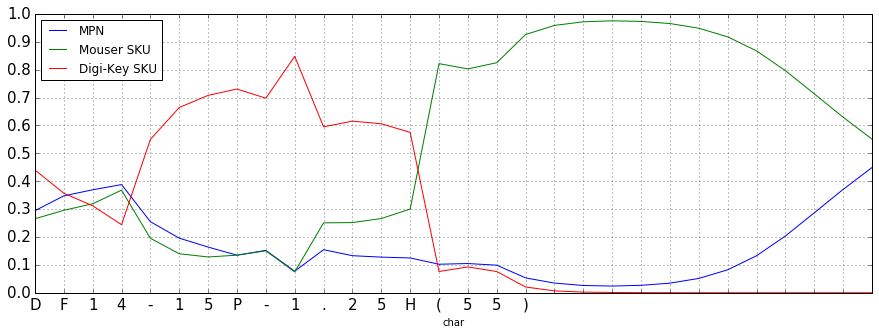

In [6]:
def char_by_char_classification_plot(partnum):
    x = df[df['partnum'] == partnum].iloc[0]['x']
    x_steps = [np.array(x[:i]) for i in range(1, len(x))]
    step_preds = []
    for i, x_step in enumerate(x_steps):
        c = partnum[i] if i < len(partnum) else ''
        pred = model.predict(np.array(x_step, ndmin=2))
        step_preds.append([c] + [v for v in pred.flat])
    df_res = pd.DataFrame(step_preds, columns=['char'] + class_names)
    return df_res.plot.line(x='char', grid=True, fontsize=15, xticks=range(len(x)-1), yticks=[0.1*v for v in range(11)], figsize=(15, 5))

char_by_char_classification_plot('DF14-15P-1.25H(55)')

The classifier starts off well with a healthy dose of pessimism. But then its misguided confidence in this being a Mouser SKU  grows by leaps and bounds, especially around less common characters like '.' and '('

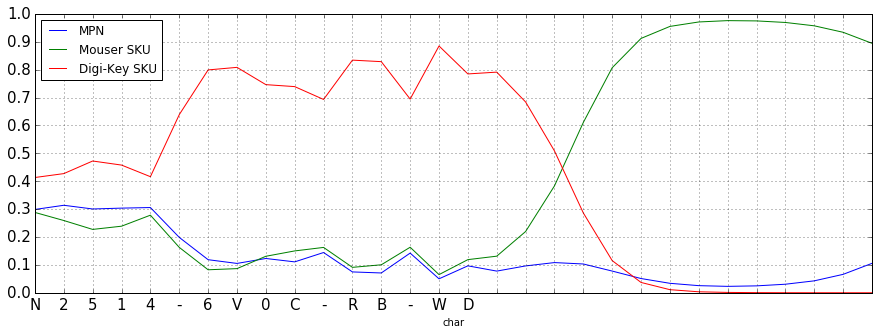

In [7]:
char_by_char_classification_plot('N2514-6V0C-RB-WD')

Here we begin an not-entirely-unreasonable bet on the Digi-Key SKU class, and pretty high probability of this NOT being Mouser. It continues this way all the way until several "end of sequence" characters past the end, where perhaps the model realizes that this is not Digi-Key (because it doesn't end "-ND"), and Mouser ends up winning, somehow.

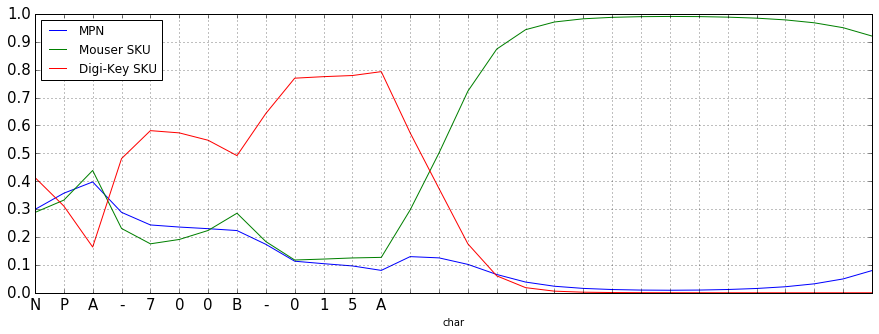

In [8]:
char_by_char_classification_plot('NPA-700B-015A')

Something similar to the previous case here.

### Digi-Key SKU false-positives

It's a bit of a nit-pick, but I'm seeing a consistent 0.763% false-positive rate on Digi-Key SKUs coming from the MPNs. I suspect a mistake in the data. Let's check it.

In [9]:
df[df.true_class_mpn & df.pred_class_digikey][['dataset', 'partnum', 'predicted_values']]

,dataset,partnum,predicted_values
10278,train,A1335LLETR-DD-T,"[0.0188813, 0.00188252, 0.979236]"
10556,train,RR1220P-152-D,"[0.137041, 0.0090699, 0.85389]"
11150,train,RR0816P-104-D,"[0.126879, 0.00860946, 0.864511]"
12718,train,RR0816P-103-D,"[0.15488, 0.0100341, 0.835086]"
12823,val,445-1271-1-ND,"[0.00229693, 8.02443e-05, 0.997623]"
14139,val,445-1316-1-ND,"[0.00214034, 6.97423e-05, 0.99779]"
14390,train,P953FCT-ND,"[0.00538572, 0.000275061, 0.994339]"
15187,train,RR1220P-273-D,"[0.173719, 0.0106338, 0.815647]"
15352,train,P180ACT-ND,"[0.005494, 0.000276823, 0.994229]"
15792,train,RR1220P-102-D,"[0.149401, 0.00936932, 0.84123]"


Looks like both our training and validation data contains some Digi-Key SKUs disguised as MPNs. We will re-label those before we train the next model.

### MPN false-positives

Some Mouser SKUs got recognized as MPNs. Let's look into that.

In [10]:
df[df.true_class_mouser & df.pred_class_mpn][['dataset', 'partnum', 'predicted_values']]

,dataset,partnum,predicted_values
1055,train,512-NDS0605,"[0.550062, 0.44983, 0.000108122]"
10605,train,621-HD01-T,"[0.838154, 0.161732, 0.000114753]"
11018,train,576-0466.200NR,"[0.534437, 0.465454, 0.000108704]"
1173,train,534-1020,"[0.691829, 0.308062, 0.000108992]"
11778,val,595-NE555DR,"[0.717318, 0.282566, 0.000115878]"
12289,val,534-5016,"[0.800593, 0.199295, 0.000111683]"
12305,train,534-54,"[0.976519, 0.0233831, 9.81602e-05]"
13160,train,279-RCT-0C,"[0.581578, 0.418315, 0.000107271]"
13530,train,534-1024,"[0.594704, 0.405192, 0.000103749]"
13874,train,534-5010,"[0.768885, 0.231003, 0.000111237]"


This potentially has something to do with the sequence length, or the number of dashes.

## Conclusions

### "Start of sequence" token?

This is where a doubt creeps in: does this model have the concept of "the beginning of the string"? We do have an "end of sequence" token - that's what we use to end and pad every sequence. What would happen if we introduced an explicit "start of sequence" token - could that eliminate some of these false positives?

### Sequence lengths?

We are padding all sequences to match the maximum length. I'm worried about long stretches of "end of sequence" token at the end of some of these training samples might be biasing the model. In the next iteration we will train the model without padding everything, which will require a bit more work.

More in upcoming part 3 of the series.